Import

In [187]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd

Load files

In [188]:
with open('IMG_1753.json') as json_data:
    data = json.load(json_data)


p1753 = np.zeros((len(data['vertices']), 2))

for i in range(0,len(data['vertices']),1):
    p1753[i,:] = data['vertices'][i]['point']

with open('IMG_1754.json') as json_data:
    data = json.load(json_data)


p1754 = np.zeros((len(data['vertices']), 2))

for i in range(0,len(data['vertices']),1):
    p1754[i,:] = data['vertices'][i]['point']

with open('IMG_1948.json') as json_data:
    data = json.load(json_data)


p1948 = np.zeros((len(data['vertices']), 2))

for i in range(0,len(data['vertices']),1):
    p1948[i,:] = data['vertices'][i]['point']

calib = np.genfromtxt('camcalib.csv', delimiter=',')
f1 = calib[0,0]
f2 = calib[2,0]

Deleting Hidden Points

In [189]:
p1948 = np.delete(p1948, 14, 0)
p1948 = np.delete(p1948, 14, 0)

Transforming points

In [190]:
img1753 = cv2.imread('IMG_1753.jpg')
img1754 = cv2.imread('IMG_1754.jpg')
img1948 = cv2.imread('IMG_1948.jpg')
def one(scalar,vector):
    """
    np.ones(Vector.length,1)*scalar - Vector 
    :param scalar: 
    :param vector: 
    :return: 
    """
    return np.ones((vector.shape[0],1))*scalar-vector
    
def fixor(points,vsize,center):
    """
    Fixing system of picture
    :param points: pre transformed points in picture system
    :param vsize: vertical size of the picture
    :param center: center of the optics on picture
    :return: 
    """
    return np.hstack((points[:,0][None].T-center[0]*np.ones((points.shape[0],1)), \
                     one(vsize,points[:,1][None].T)-center[1]*np.ones((points.shape[0],1))))
                     
p1753_new = fixor(p1753, img1753.shape[0], calib[0,1:3])
p1754_new = fixor(p1754, img1754.shape[0], calib[0,1:3])
p1948_new = fixor(p1948, img1948.shape[0], calib[1,1:3])

Calculate Air Base

In [191]:
def ab(d,f1,f2,xy1,xy2,xy3,xy4):
    """
    Function of air base calculating
    :param d: Measured size of a line in world
    :param f1: Focal length of camera 1
    :param f2: Focal length of camera 2
    :param xy1: Closest point of line to picture center of pic1
    :param xy2: Far point of line to picture center of pic1
    :param xy3: Closest point of line to picture center of pic2
    :param xy4: Far point of line to picture center of pic2
    :return: 
    """
    px1 = np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)
    px2 = np.sqrt((xy4[0]-xy3[0])**2+(xy4[1]-xy3[1])**2)
    
    # px1 = np.sqrt((xy2[0])**2+(xy2[1])**2)-np.sqrt((xy1[0])**2+(xy1[1])**2)
    # px2 = np.sqrt((xy4[0])**2+(xy4[1])**2)-np.sqrt((xy3[0])**2+(xy3[1])**2)
    
    
    a1 =f1/px1-f2/px2
    a2 =xy2[0]/px1-xy4[0]/px2
    a3 =xy2[1]/px1-xy4[1]/px2
    
    return np.sqrt(a1**2+a2**2+a3**2)

b1 = ab(0.24, f1, f2, p1753_new[6,:], p1948_new[6,:], p1753_new[9,:], p1948_new[9,:])
b2 = ab(0.24, f1, f2, p1754_new[6,:], p1948_new[6,:], p1754_new[9,:], p1948_new[9,:])

print('B1=',np.round(b1,3),'m\nB2=',np.round(b2,3),'m')

B1= 0.444 m
B2= 0.591 m


Calculating XYH

In [193]:
def Stero3DCompute(b,f,points,points2):
    """
    Calculating XYH of points from points taken by parallel face cameras
    :param b1: Air base
    :param f1: Focal length camera 1
    :param points: Points on picture from camera 1
    :param points2: Points on picture from camera 2
    :return: 
    """
    def px(xy1,xy2):
        """
        Calculating parallax angle
        :param xy1: Point from picture 1
        :param xy2: Point from picture 2
        :return: 
        """
        return np.sqrt((xy2[0]-xy1[0])**2+(xy2[1]-xy1[1])**2)
        
    result = np.zeros((points.shape[0],3)) 
    for i in range(points.shape[0]):
        result[i,2] = b*(f/px(points[i],points2[i]))
        #print(px(points2[i],points[i]))
        result[i,0] = result[i,2]*points[i,0]/f
        result[i,1] = result[i,2]*points[i,1]/f
    return result

plocations = Stero3DCompute(b1,f1,p1948_new, p1753_new)
plocations2 = Stero3DCompute(b2,f2, p1948_new, p1754_new)

Plot XYH

Text(0.5, 0, 'H Label')

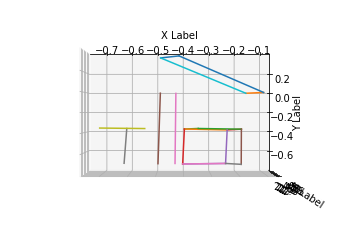

In [196]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(90, -90)

for i in range(0,plocations2.shape[0]-11,2):
    ax.plot([plocations2[i,0],plocations2[i+1,0]], \
               [plocations2[i,1],plocations2[i+1,1]], \
               [plocations2[i,2],plocations2[i+1,2]])
for i in range(12,plocations2.shape[0]-1,2):
    ax.plot([plocations2[i,0],plocations2[i+1,0]], \
               [plocations2[i,1],plocations2[i+1,1]], \
               [plocations2[i,2],plocations2[i+1,2]])
for i in [[0,2],[1,3],[4,6],[5,7],[4,8],[6,9],[7,10],[8,9],[9,10]]:
    ax.plot([plocations2[i[0],0],plocations2[i[1],0]], \
               [plocations2[i[0],1],plocations2[i[1],1]], \
               [plocations2[i[0],2],plocations2[i[1],2]])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('H Label')
#plt.axis('equal')


XYH Results

In [197]:
df1 = pd.DataFrame(plocations)
df1.columns = ['X', 'Y', 'H']
print(df1)
df2 = pd.DataFrame(plocations2)
df2.columns = ['X', 'Y', 'H']
print(df2)


           X         Y         H
0  -0.272124  0.188407  1.444639
1  -0.235437  0.190222  1.513304
2  -0.093307 -0.004355  1.405032
3  -0.061420 -0.003162  1.466710
4  -0.222823 -0.208585  1.360050
5  -0.195324 -0.203313  1.433731
6  -0.129124 -0.212859  1.346497
7  -0.103172 -0.206711  1.413033
8  -0.225498 -0.407697  1.360704
9  -0.132657 -0.409566  1.343671
10 -0.103845 -0.405035  1.417674
11 -0.362267 -0.004018  1.403083
12 -0.274384 -0.004763  1.428027
13 -0.278725 -0.398603  1.433023
14 -0.241671 -0.006850  1.441872
15 -0.243951 -0.397586  1.445303
16 -0.353130 -0.209490  1.337155
17 -0.354839 -0.410688  1.332910
18 -0.406801 -0.203203  1.349873
19 -0.307123 -0.204467  1.366838
20 -0.446570  0.002042  1.477212
           X         Y         H
0  -0.483938  0.335058  2.569418
1  -0.416279  0.336333  2.676008
2  -0.166273 -0.007761  2.504061
3  -0.108860 -0.005605  2.599878
4  -0.395835 -0.370542  2.416354
5  -0.345028 -0.359140  2.532906
6  -0.230600 -0.380140  2.404964
7  -0.1832